In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\Ghalib\Documents\lahore_housing_prices - lahore_housing_prices.csv")

df1 = df.drop(['house_id'], axis = 'columns')

df2 = df1.dropna()
df2.isnull().value_counts().unstack()
def area_to_sqft(area):
    if 'Marla' in area:
        return float(area.split()[0]) * 272.251
    elif 'Kanal' in area:
        return float(area.split()[0]) * 5445
    return None

df3 = df2.copy()
df3["Square_foot"] = df3['Area'].apply(area_to_sqft)
df3['Price_per_Square_foot'] = df3['Price'] / df3["Square_foot"]

def house_size(area):
    if area <= 2722.51:
        return 'Small'
    elif area <= 5445.01:
        return 'Medium'
    else:
        return 'Large'

df3['House_by_Size'] = df3["Square_foot"].apply(house_size)


In [4]:
loc_stat = df3.groupby('Location')['Location'].agg('count').sort_values(ascending = False)
loc_stats_lessthan5 = loc_stat[loc_stat < 5].index  # Get the index (location names)

# Replace these locations with 'other'
df3['Location'] = df3['Location'].apply(lambda x: 'other' if x in loc_stats_lessthan5 else x)

# Optional: Check if the replacement worked
print(df3['Location'].value_counts())

Location
DHA Defence, Lahore, Punjab                               4845
Bahria Town, Lahore, Punjab                               1767
Askari, Lahore, Punjab                                     843
Raiwind Road, Lahore, Punjab                               599
Johar Town, Lahore, Punjab                                 511
                                                          ... 
TIP Housing Society, Lahore, Punjab                          5
BOR - Board of Revenue Housing Society, Lahore, Punjab       5
Shalimar Link Road, Lahore, Punjab                           5
Airline Housing Society, Lahore, Punjab                      5
Royal Residencia, Lahore, Punjab                             5
Name: count, Length: 145, dtype: int64


In [5]:
other_count = df3['Location'].value_counts().get('other', 0)
print(f"Number of rows labeled as 'other': {other_count}")

Number of rows labeled as 'other': 320


In [6]:
total_other_rows = loc_stat[loc_stat < 5].sum()
print(f"Total rows grouped into 'other': {total_other_rows}")

Total rows grouped into 'other': 320


In [7]:
#Detect and remove that how many rows contain those values that has less bath and beds and same area and location but have high price compare to more bath and beds
""" For Eg.
Airline Housing Society, Lahore, Punjab |	1 Kanal	| 5 |	5 |	60000000 
Airline Housing Society, Lahore, Punjab |	1 Kanal | 6 |	6 |	56000000
less baths & beds have 6 crore and more beds and baths have 5.6 crore
"""
def detect_inconsistent_prices(df):
    # Sort the data by Location, Square_foot, Bedroom(s), Bath(s), and Price
    df = df.sort_values(by=['Location', 'Square_foot', 'Bedroom(s)', 'Bath(s)', 'Price'], ascending=[True, True, True, True, False])
    
    # Group by Location and Square_foot to identify inconsistencies
    groups = df.groupby(['Location', 'Square_foot'])
    
    # List to keep track of indices of inconsistent rows
    inconsistent_indices = []
    
    for _, group in groups:
        # Compare rows within each group
        max_price = None
        max_bed = None
        max_bath = None
        
        for index, row in group.iterrows():
            beds = row['Bedroom(s)']
            baths = row['Bath(s)']
            price = row['Price']
            
            # If a property with fewer beds and baths has a higher price, flag it
            if max_price is not None and (beds < max_bed or baths < max_bath) and price > max_price:
                inconsistent_indices.append(index)
            else:
                # Update max values
                max_price = price
                max_bed = beds
                max_bath = baths
    
    # Return the count of inconsistent rows
    return inconsistent_indices

# Apply the function to detect inconsistent rows
inconsistent_indices = detect_inconsistent_prices(df3)

# Print results
print(f"Total number of inconsistent rows: {len(inconsistent_indices)}")

Total number of inconsistent rows: 897


In [8]:
# I use df5 here instead of df4 bcz i use df4 earlier but not using when i run whole code

df5 = df3.drop(index=inconsistent_indices)
print(f"Dataset size after removal: {len(df5)}")

Dataset size after removal: 16264


In [9]:
import pandas as pd
import numpy as np

# Assuming df5 is your DataFrame and it has the necessary columns
# Step 1: Calculate price per square foot
df5['Price_per_sqft'] = df5['Price'] / df5['Square_foot']

# Step 2: Group by Location, Area, and Type
grouped = df5.groupby(['Location', 'Area', 'Type'])

# Step 3: Calculate mean and standard deviation of price per square foot for each group
price_per_sqft_stats = grouped['Price_per_sqft'].agg(['mean', 'std']).reset_index()

# Merge the stats back to the original data
df5 = pd.merge(df5, price_per_sqft_stats, on=['Location', 'Area', 'Type'])

# Step 4: Calculate the threshold for identifying outliers (e.g., 2 standard deviations from the mean)
df5['Price_per_sqft_zscore'] = (df5['Price_per_sqft'] - df5['mean']) / df5['std']

# Flag the rows where the z-score is greater than 2 (outliers)
outliers = df5[df5['Price_per_sqft_zscore'] > 2]

print(f"Outliers found: {len(outliers)}")
print(outliers[['Location', 'Area', 'Type', 'Price', 'Square_foot', 'Price_per_sqft', 'Price_per_sqft_zscore']])

Outliers found: 401
                                       Location      Area   Type        Price  \
8                   DHA Defence, Lahore, Punjab   1 Kanal  House  149000000.0   
37                  DHA Defence, Lahore, Punjab   1 Kanal  House  180000000.0   
47                  DHA Defence, Lahore, Punjab   1 Kanal  House  160000000.0   
114                 DHA Defence, Lahore, Punjab   1 Kanal  House  150000000.0   
128                 DHA Defence, Lahore, Punjab   1 Kanal  House  155000000.0   
...                                         ...       ...    ...          ...   
14483                 Samanabad, Lahore, Punjab   3 Marla  House   19000000.0   
14545                 Samanabad, Lahore, Punjab   2 Marla  House   10000000.0   
15276  Marghzar Officers Colony, Lahore, Punjab  10 Marla  House   55000000.0   
15501  Marghzar Officers Colony, Lahore, Punjab   5 Marla  House   23500000.0   
15879        Mustafabad Lalyani, Lahore, Punjab   3 Marla  House    3600000.0   

       

In [10]:
#Removing the outlier
df6 = df5[df5['Price_per_sqft_zscore'] <= 2]
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14913 entries, 0 to 16243
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   14913 non-null  object 
 1   Location               14913 non-null  object 
 2   Area                   14913 non-null  object 
 3   Bath(s)                14913 non-null  float64
 4   Bedroom(s)             14913 non-null  float64
 5   Price                  14913 non-null  float64
 6   Square_foot            14913 non-null  float64
 7   Price_per_Square_foot  14913 non-null  float64
 8   House_by_Size          14913 non-null  object 
 9   Price_per_sqft         14913 non-null  float64
 10  mean                   14913 non-null  float64
 11  std                    14913 non-null  float64
 12  Price_per_sqft_zscore  14913 non-null  float64
dtypes: float64(9), object(4)
memory usage: 1.6+ MB


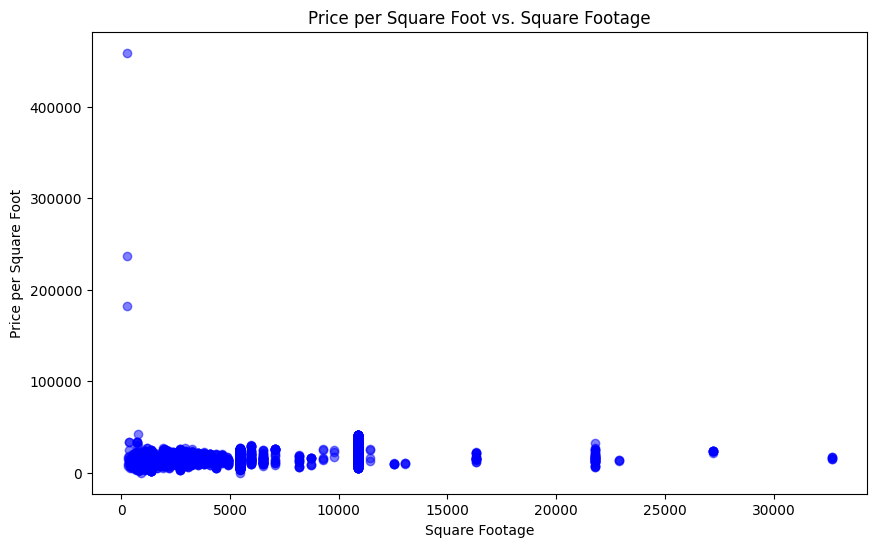

In [11]:
import matplotlib.pyplot as plt

# Plotting the price per square foot for each group
plt.figure(figsize=(10, 6))
plt.scatter(df6['Square_foot'], df6['Price_per_sqft'], alpha=0.5, color='blue', label='Properties')
plt.xlabel('Square Footage')
plt.ylabel('Price per Square Foot')
plt.title('Price per Square Foot vs. Square Footage')
plt.show()

In [12]:
#removing outliers that shown in above graph
# Calculate price per square foot
df6['Price_per_sqft'] = df6['Price'] / df6['Square_foot']

# Calculate the z-score for price per square foot
from scipy.stats import zscore
df6['z_score'] = zscore(df6['Price_per_sqft'])

# Identify outliers based on z-score (e.g., threshold of 3)
outliers = df6[df6['z_score'] > 3]  # or df3[df3['z_score'] < -3]
print("Number of outliers detected:", len(outliers))
print(outliers)

Number of outliers detected: 78
        Type                     Location       Area  Bath(s)  Bedroom(s)  \
3863   House  DHA Defence, Lahore, Punjab    2 Kanal      6.0         6.0   
3865   House  DHA Defence, Lahore, Punjab    2 Kanal      6.0         6.0   
3876   House  DHA Defence, Lahore, Punjab    2 Kanal      6.0         5.0   
3880   House  DHA Defence, Lahore, Punjab    2 Kanal      6.0         6.0   
3883   House  DHA Defence, Lahore, Punjab    2 Kanal      6.0         5.0   
...      ...                          ...        ...      ...         ...   
12558   Flat      Gulberg, Lahore, Punjab  2.8 Marla      1.0         1.0   
13246  House  DHA Defence, Lahore, Punjab    4 Kanal      6.0         6.0   
14651  House  DHA Defence, Lahore, Punjab    1 Marla      6.0         5.0   
14652  House  DHA Defence, Lahore, Punjab    1 Marla      3.0         2.0   
14653  House  DHA Defence, Lahore, Punjab    1 Marla      3.0         2.0   

             Price  Square_foot  Price_per_

C:\Users\Ghalib\AppData\Local\Temp\ipykernel_12624\892672663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['Price_per_sqft'] = df6['Price'] / df6['Square_foot']
C:\Users\Ghalib\AppData\Local\Temp\ipykernel_12624\892672663.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['z_score'] = zscore(df6['Price_per_sqft'])


In [13]:
df7 = df6[df6['z_score'].abs() <= 3]  # Removing outliers with z-score > 3
print(f"Rows after removing outliers: {len(df7)}")

Rows after removing outliers: 14835


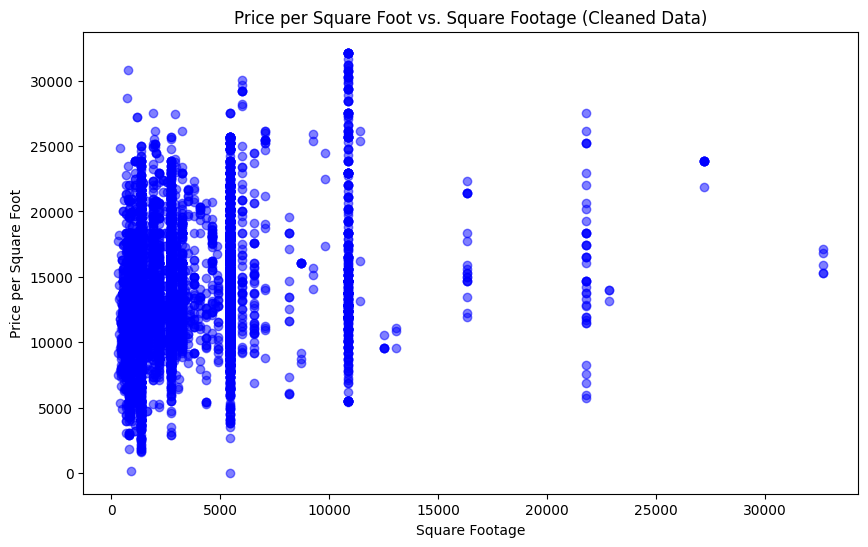

In [14]:
# Plotting after removing outliers
plt.figure(figsize=(10, 6))
plt.scatter(df7['Square_foot'], df7['Price_per_sqft'], alpha=0.5, color='blue', label='Properties')
plt.xlabel('Square Footage')
plt.ylabel('Price per Square Foot')
plt.title('Price per Square Foot vs. Square Footage (Cleaned Data)')
plt.show()

            Bath(s)    Bedroom(s)         Price   Square_foot  \
count  14835.000000  14835.000000  1.483500e+04  14835.000000   
mean       4.743579      4.142366  4.441453e+07   3078.801049   
std        1.316415      1.247981  4.659613e+07   2585.465482   
min        1.000000      1.000000  1.150000e+05    326.701200   
25%        4.000000      3.000000  1.800000e+07   1361.255000   
50%        5.000000      4.000000  3.100000e+07   2722.510000   
75%        6.000000      5.000000  5.750000e+07   5445.000000   
max       10.000000     11.000000  6.500000e+08  32670.000000   

       Price_per_Square_foot  Price_per_sqft          mean           std  \
count           14835.000000    14835.000000  14835.000000  14835.000000   
mean            13833.304794    13833.304794  14149.420797   2906.917649   
std              3927.002239     3927.002239   3171.583660   1910.159120   
min                21.120294       21.120294   2519.733628      0.000000   
25%             11386.551381    11

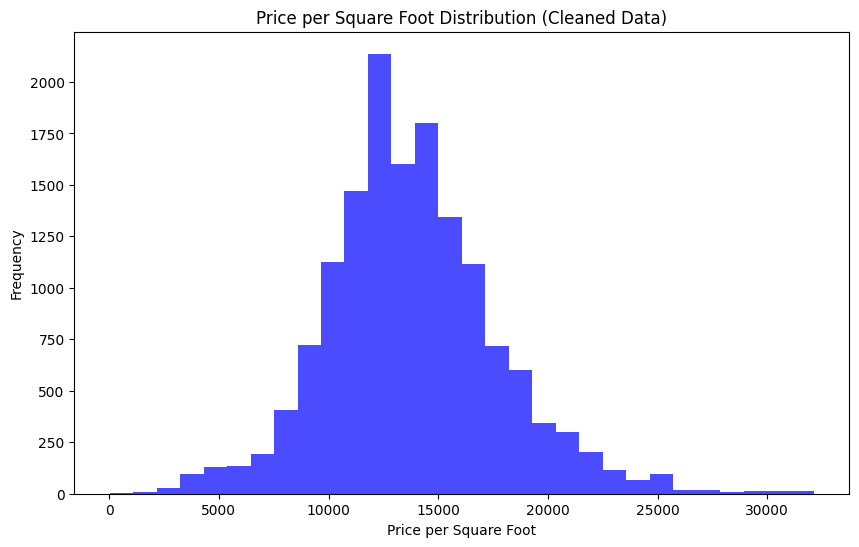

In [15]:
print(df7.describe())

# Check for any remaining unusual patterns
plt.figure(figsize=(10, 6))
plt.hist(df7['Price_per_sqft'], bins=30, color='blue', alpha=0.7)
plt.title('Price per Square Foot Distribution (Cleaned Data)')
plt.xlabel('Price per Square Foot')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Im thinkking to make saperate 2 columns for Area 1 with number and 2nd with Marla or kanal like: 2 | Marla

In [27]:
df7["Area"].unique()

array(['1 Kanal', '10 Marla', '8 Marla', '5 Marla', '2 Kanal',
       '1.3 Kanal', '3 Marla', '4 Marla', '12 Marla', '1.1 Kanal',
       '9 Marla', '6.1 Marla', '7 Marla', '3.5 Marla', '6 Marla',
       '2.5 Marla', '1.3 Marla', '2.3 Marla', '2.2 Marla', '2.6 Marla',
       '7.3 Marla', '11 Marla', '1.8 Marla', '2.7 Marla', '11.1 Marla',
       '4.2 Marla', '1.4 Marla', '8.7 Marla', '2 Marla', '1.6 Kanal',
       '1.6 Marla', '5.3 Marla', '1.7 Kanal', '1.2 Kanal', '14 Marla',
       '3.3 Marla', '5.4 Marla', '5.2 Marla', '3.8 Marla', '17 Marla',
       '18 Marla', '4 Kanal', '11.5 Marla', '2.8 Marla', '3 Kanal',
       '2.3 Kanal', '7.8 Marla', '4.5 Marla', '6.3 Marla', '1.7 Marla',
       '3.6 Marla', '1.5 Kanal', '6 Kanal', '11.2 Marla', '3.2 Marla',
       '13 Marla', '12.9 Marla', '5.5 Marla', '10.7 Marla', '2.4 Marla',
       '7.5 Marla', '1.9 Marla', '2.1 Marla', '10.8 Marla', '15 Marla',
       '4.4 Marla', '4.6 Marla', '5 Kanal', '16 Marla', '5.6 Marla',
       '10.1 Marla', '9

In [16]:
# Drop unnecessary columns
df8 = df7.drop(['mean', 'std', 'Price_per_sqft_zscore', 'z_score', 'Price_per_Square_foot'], axis=1)

# Verify the remaining columns
print(df8.columns)

Index(['Type', 'Location', 'Area', 'Bath(s)', 'Bedroom(s)', 'Price',
       'Square_foot', 'House_by_Size', 'Price_per_sqft'],
      dtype='object')


In [17]:
# Function to split Area into numeric value and unit
def split_area(area):
    parts = area.split()
    if len(parts) == 2:
        return float(parts[0]), parts[1]  # Numeric value, Unit
    return None, None  # If no valid split

# Create two new columns for Area
df8['Area_value'], df8['Area_unit'] = zip(*df8['Area'].apply(split_area))

# Check the result
print(df8[['Area', 'Area_value', 'Area_unit']].head())

      Area  Area_value Area_unit
0  1 Kanal         1.0     Kanal
1  1 Kanal         1.0     Kanal
2  1 Kanal         1.0     Kanal
3  1 Kanal         1.0     Kanal
4  1 Kanal         1.0     Kanal


In [18]:
df8

,Type,Location,Area,Bath(s),Bedroom(s),Price,Square_foot,House_by_Size,Price_per_sqft,Area_value,Area_unit
0,House,"DHA Defence, Lahore, Punjab",1 Kanal,6.0,5.0,75500000.0,5445.0000,Medium,13865.932048,1.0,Kanal
1,House,"DHA Defence, Lahore, Punjab",1 Kanal,6.0,5.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal
2,House,"DHA Defence, Lahore, Punjab",1 Kanal,6.0,5.0,87000000.0,5445.0000,Medium,15977.961433,1.0,Kanal
3,House,"DHA Defence, Lahore, Punjab",1 Kanal,6.0,5.0,64500000.0,5445.0000,Medium,11845.730028,1.0,Kanal
4,House,"DHA Defence, Lahore, Punjab",1 Kanal,6.0,6.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal
...,...,...,...,...,...,...,...,...,...,...,...
16195,House,"HBFC Housing Society, Lahore, Punjab",17.5 Marla,6.0,5.0,62000000.0,4764.3925,Medium,13013.201578,17.5,Marla
16233,House,"DHA Defence, Lahore, Punjab",2.5 Marla,4.0,3.0,15500000.0,680.6275,Small,22773.102762,2.5,Marla
16234,House,"DHA Defence, Lahore, Punjab",2.5 Marla,4.0,3.0,14500000.0,680.6275,Small,21303.870326,2.5,Marla
16242,House,"New Lahore City, Lahore, Punjab",5.5 Marla,5.0,3.0,16500000.0,1497.3805,Small,11019.243272,5.5,Marla


In [19]:
df8 = df8.drop("Area", axis = "columns")

In [34]:
#All unnceccery column are droped now move to one hot encodding

In [38]:
df8

,Type,Location,Bath(s),Bedroom(s),Price,Square_foot,House_by_Size,Price_per_sqft,Area_value,Area_unit
0,House,"DHA Defence, Lahore, Punjab",6.0,5.0,75500000.0,5445.0000,Medium,13865.932048,1.0,Kanal
1,House,"DHA Defence, Lahore, Punjab",6.0,5.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal
2,House,"DHA Defence, Lahore, Punjab",6.0,5.0,87000000.0,5445.0000,Medium,15977.961433,1.0,Kanal
3,House,"DHA Defence, Lahore, Punjab",6.0,5.0,64500000.0,5445.0000,Medium,11845.730028,1.0,Kanal
4,House,"DHA Defence, Lahore, Punjab",6.0,6.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal
...,...,...,...,...,...,...,...,...,...,...
16195,House,"HBFC Housing Society, Lahore, Punjab",6.0,5.0,62000000.0,4764.3925,Medium,13013.201578,17.5,Marla
16233,House,"DHA Defence, Lahore, Punjab",4.0,3.0,15500000.0,680.6275,Small,22773.102762,2.5,Marla
16234,House,"DHA Defence, Lahore, Punjab",4.0,3.0,14500000.0,680.6275,Small,21303.870326,2.5,Marla
16242,House,"New Lahore City, Lahore, Punjab",5.0,3.0,16500000.0,1497.3805,Small,11019.243272,5.5,Marla


In [41]:
df8["Area_unit"].unique()

array(['Kanal', 'Marla'], dtype=object)

In [20]:
df9 = pd.get_dummies(df8, columns=['Location'], drop_first=True)

# Check the updated DataFrame
print(df9.head())

    Type  Bath(s)  Bedroom(s)       Price  Square_foot House_by_Size  \
0  House      6.0         5.0  75500000.0       5445.0        Medium   
1  House      6.0         5.0  72000000.0       5445.0        Medium   
2  House      6.0         5.0  87000000.0       5445.0        Medium   
3  House      6.0         5.0  64500000.0       5445.0        Medium   
4  House      6.0         6.0  72000000.0       5445.0        Medium   

   Price_per_sqft  Area_value Area_unit  \
0    13865.932048         1.0     Kanal   
1    13223.140496         1.0     Kanal   
2    15977.961433         1.0     Kanal   
3    11845.730028         1.0     Kanal   
4    13223.140496         1.0     Kanal   

   Location_Al Haram Garden, Lahore, Punjab  ...  \
0                                     False  ...   
1                                     False  ...   
2                                     False  ...   
3                                     False  ...   
4                                     False  ...

In [21]:
df9

,Type,Bath(s),Bedroom(s),Price,Square_foot,House_by_Size,Price_per_sqft,Area_value,Area_unit,"Location_Al Haram Garden, Lahore, Punjab",...,"Location_Tariq Gardens, Lahore, Punjab","Location_Thokar Niaz Baig, Lahore, Punjab","Location_Township, Lahore, Punjab","Location_UET Housing Society, Lahore, Punjab","Location_Valencia Housing Society, Lahore, Punjab","Location_Vital Homes Housing Scheme, Lahore, Punjab","Location_Walton Road, Lahore, Punjab","Location_Wapda Town, Lahore, Punjab","Location_Zaheer Villas, Lahore, Punjab",Location_other
0,House,6.0,5.0,75500000.0,5445.0000,Medium,13865.932048,1.0,Kanal,False,...,False,False,False,False,False,False,False,False,False,False
1,House,6.0,5.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal,False,...,False,False,False,False,False,False,False,False,False,False
2,House,6.0,5.0,87000000.0,5445.0000,Medium,15977.961433,1.0,Kanal,False,...,False,False,False,False,False,False,False,False,False,False
3,House,6.0,5.0,64500000.0,5445.0000,Medium,11845.730028,1.0,Kanal,False,...,False,False,False,False,False,False,False,False,False,False
4,House,6.0,6.0,72000000.0,5445.0000,Medium,13223.140496,1.0,Kanal,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,House,6.0,5.0,62000000.0,4764.3925,Medium,13013.201578,17.5,Marla,False,...,False,False,False,False,False,False,False,False,False,False
16233,House,4.0,3.0,15500000.0,680.6275,Small,22773.102762,2.5,Marla,False,...,False,False,False,False,False,False,False,False,False,False
16234,House,4.0,3.0,14500000.0,680.6275,Small,21303.870326,2.5,Marla,False,...,False,False,False,False,False,False,False,False,False,False
16242,House,5.0,3.0,16500000.0,1497.3805,Small,11019.243272,5.5,Marla,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
###This part of code will convert the area unit (Marla|Kanal) into square foot. we just need During prediction: Pass the Square_foot value (instead of Area_value and Area_unit) to the ML model.###

def area_to_sqft(area_value, area_unit):
    """
    Convert user area input to square feet.
    :param area_value: float, numeric value of area
    :param area_unit: str, 'Marla' or 'Kanal'
    :return: float, area in square feet
    """
    if area_unit.lower() == 'marla':
        return area_value * 225  # 1 Marla = 225 sqft
    elif area_unit.lower() == 'kanal':
        return area_value * 5445  # 1 Kanal = 5445 sqft
    else:
        raise ValueError("Invalid unit. Please use 'Marla' or 'Kanal'.")

# Example usage:
user_value = 299  # User inputs 2.5
user_unit = 'Marla'  # User selects 'Marla'

# Convert to sqft
square_foot = area_to_sqft(user_value, user_unit)
print("Area in Square Feet:", square_foot)

Area in Square Feet: 67275


In [25]:
df10 = df9.drop(['Area_value', 'Area_unit', 'Price_per_sqft', "House_by_Size"], axis=1)

df10

,Type,Bath(s),Bedroom(s),Price,Square_foot,"Location_Al Haram Garden, Lahore, Punjab","Location_Al Jalil Garden, Lahore, Punjab","Location_Al Noor Park Housing Society, Lahore, Punjab","Location_Al Rehman Garden, Lahore, Punjab","Location_Al-Hafiz Town, Lahore, Punjab",...,"Location_Tariq Gardens, Lahore, Punjab","Location_Thokar Niaz Baig, Lahore, Punjab","Location_Township, Lahore, Punjab","Location_UET Housing Society, Lahore, Punjab","Location_Valencia Housing Society, Lahore, Punjab","Location_Vital Homes Housing Scheme, Lahore, Punjab","Location_Walton Road, Lahore, Punjab","Location_Wapda Town, Lahore, Punjab","Location_Zaheer Villas, Lahore, Punjab",Location_other
0,House,6.0,5.0,75500000.0,5445.0000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,House,6.0,5.0,72000000.0,5445.0000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,House,6.0,5.0,87000000.0,5445.0000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,House,6.0,5.0,64500000.0,5445.0000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,House,6.0,6.0,72000000.0,5445.0000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,House,6.0,5.0,62000000.0,4764.3925,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16233,House,4.0,3.0,15500000.0,680.6275,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16234,House,4.0,3.0,14500000.0,680.6275,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
16242,House,5.0,3.0,16500000.0,1497.3805,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
df10 = pd.get_dummies(df10, columns=['Type'], drop_first=True)

In [27]:
df10

,Bath(s),Bedroom(s),Price,Square_foot,"Location_Al Haram Garden, Lahore, Punjab","Location_Al Jalil Garden, Lahore, Punjab","Location_Al Noor Park Housing Society, Lahore, Punjab","Location_Al Rehman Garden, Lahore, Punjab","Location_Al-Hafiz Town, Lahore, Punjab","Location_Al-Hamad Colony (AIT), Lahore, Punjab",...,"Location_Thokar Niaz Baig, Lahore, Punjab","Location_Township, Lahore, Punjab","Location_UET Housing Society, Lahore, Punjab","Location_Valencia Housing Society, Lahore, Punjab","Location_Vital Homes Housing Scheme, Lahore, Punjab","Location_Walton Road, Lahore, Punjab","Location_Wapda Town, Lahore, Punjab","Location_Zaheer Villas, Lahore, Punjab",Location_other,Type_House
0,6.0,5.0,75500000.0,5445.0000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,6.0,5.0,72000000.0,5445.0000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,6.0,5.0,87000000.0,5445.0000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,6.0,5.0,64500000.0,5445.0000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,6.0,6.0,72000000.0,5445.0000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,6.0,5.0,62000000.0,4764.3925,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16233,4.0,3.0,15500000.0,680.6275,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16234,4.0,3.0,14500000.0,680.6275,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16242,5.0,3.0,16500000.0,1497.3805,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [28]:
df10.Type_House.unique()

array([ True, False])

In [29]:
X = df10.drop("Price", axis = "columns")

,Bath(s),Bedroom(s),Square_foot,"Location_Al Haram Garden, Lahore, Punjab","Location_Al Jalil Garden, Lahore, Punjab","Location_Al Noor Park Housing Society, Lahore, Punjab","Location_Al Rehman Garden, Lahore, Punjab","Location_Al-Hafiz Town, Lahore, Punjab","Location_Al-Hamad Colony (AIT), Lahore, Punjab","Location_Al-Hamd Park, Lahore, Punjab",...,"Location_Thokar Niaz Baig, Lahore, Punjab","Location_Township, Lahore, Punjab","Location_UET Housing Society, Lahore, Punjab","Location_Valencia Housing Society, Lahore, Punjab","Location_Vital Homes Housing Scheme, Lahore, Punjab","Location_Walton Road, Lahore, Punjab","Location_Wapda Town, Lahore, Punjab","Location_Zaheer Villas, Lahore, Punjab",Location_other,Type_House
0,6.0,5.0,5445.0000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,6.0,5.0,5445.0000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,6.0,5.0,5445.0000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,6.0,5.0,5445.0000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,6.0,6.0,5445.0000,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,6.0,5.0,4764.3925,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16233,4.0,3.0,680.6275,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16234,4.0,3.0,680.6275,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
16242,5.0,3.0,1497.3805,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [30]:
y = df10.Price

In [31]:
!pip install scikit-learn

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.830556980483396

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predictions on the test set
y_pred = lr_clf.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 9657217.736858008
Mean Squared Error (MSE): 349128583792777.6
Root Mean Squared Error (RMSE): 18684982.84165061


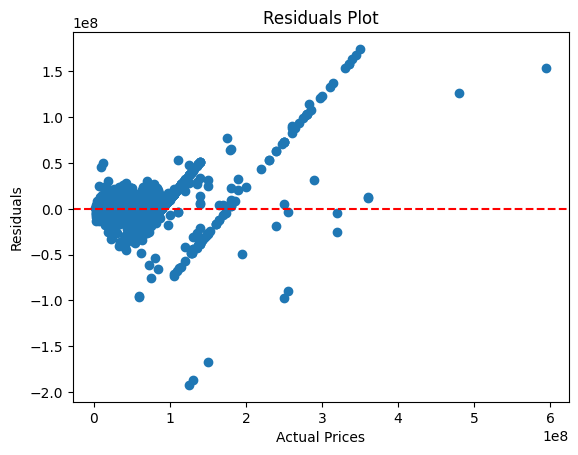

In [74]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

In [83]:
lr_clf.predict(1,10,5000,2,2)

TypeError: predict() takes 2 positional arguments but 6 were given

In [80]:
np.where(X.columns=='Type_House')[0][0]

138

In [1]:
#This is not working check for below code
def predict_price(types,Location,sqft,baths,beds):
    loc_index = np.where(X.columns==Location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = types
    x[1] = sqft
    x[2] = baths
    x[3] = beds
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [85]:
#This is not working check for below code

predict_price("Location_Allama Iqbal Town, Lahore, Punjab",1,5000,2,2)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [86]:
df10.columns

Index(['Bath(s)', 'Bedroom(s)', 'Price', 'Square_foot',
       'Location_Al Haram Garden, Lahore, Punjab',
       'Location_Al Jalil Garden, Lahore, Punjab',
       'Location_Al Noor Park Housing Society, Lahore, Punjab',
       'Location_Al Rehman Garden, Lahore, Punjab',
       'Location_Al-Hafiz Town, Lahore, Punjab',
       'Location_Al-Hamad Colony (AIT), Lahore, Punjab',
       ...
       'Location_Thokar Niaz Baig, Lahore, Punjab',
       'Location_Township, Lahore, Punjab',
       'Location_UET Housing Society, Lahore, Punjab',
       'Location_Valencia Housing Society, Lahore, Punjab',
       'Location_Vital Homes Housing Scheme, Lahore, Punjab',
       'Location_Walton Road, Lahore, Punjab',
       'Location_Wapda Town, Lahore, Punjab',
       'Location_Zaheer Villas, Lahore, Punjab', 'Location_other',
       'Type_House'],
      dtype='object', length=140)

In [87]:
X.columns

Index(['Bath(s)', 'Bedroom(s)', 'Square_foot',
       'Location_Al Haram Garden, Lahore, Punjab',
       'Location_Al Jalil Garden, Lahore, Punjab',
       'Location_Al Noor Park Housing Society, Lahore, Punjab',
       'Location_Al Rehman Garden, Lahore, Punjab',
       'Location_Al-Hafiz Town, Lahore, Punjab',
       'Location_Al-Hamad Colony (AIT), Lahore, Punjab',
       'Location_Al-Hamd Park, Lahore, Punjab',
       ...
       'Location_Thokar Niaz Baig, Lahore, Punjab',
       'Location_Township, Lahore, Punjab',
       'Location_UET Housing Society, Lahore, Punjab',
       'Location_Valencia Housing Society, Lahore, Punjab',
       'Location_Vital Homes Housing Scheme, Lahore, Punjab',
       'Location_Walton Road, Lahore, Punjab',
       'Location_Wapda Town, Lahore, Punjab',
       'Location_Zaheer Villas, Lahore, Punjab', 'Location_other',
       'Type_House'],
      dtype='object', length=139)

In [50]:
def predict_price(baths, beds, sqft, location, types):
    # Prepend 'Location_' to the location to match the one-hot encoded column names
    location_column = f"Location_{location}"
    
    # Check if the location exists in X.columns
    loc_index = -1
    if location_column in X.columns:
        loc_index = np.where(X.columns == location_column)[0][0]
    
    # Create an input array of zeros
    x = np.zeros(len(X.columns))
    x[0] = baths       # Bath(s) is the first column
    x[1] = beds        # Bedroom(s) is the second column
    x[2] = sqft        # Square_foot is the third column
    
    # If location exists, set its index to 1
    if loc_index >= 0:
        x[loc_index] = 1
    
    # Assign Type_House (last column) based on types (0 or 1)
    x[-1] = types      # Type_House comes last in your DataFrame

    # Predict the price using the model
    return lr_clf.predict([x])[0]

In [54]:
# Example Inputs
baths = 5
beds = 5
sqft = 3811.514
location = "Wapda Town, Lahore, Punjab"
types = 1 # 1 for House, 0 for Flat

# Prediction
predicted_price = predict_price(baths, beds, sqft, location, types)
print(f"Predicted Price: {predicted_price}")

Predicted Price: 45397184.93051989


c:\users\ghalib\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [55]:
import pickle
with open ("Lahore_Real_Estate_Price_Prediction_model.picle" , 'wb') as f:
    pickle.dump(lr_clf,f)

In [56]:
import json

# Convert X.columns to a list
columns_list = X.columns.tolist()

# Save the list into a JSON file
with open("columns.json", "w") as f:
    json.dump(columns_list, f)

print("Column names saved successfully to columns.json")

Column names saved successfully to columns.json


In [113]:
print(df10['Price'].describe())


count    1.483500e+04
mean     4.441453e+07
std      4.659613e+07
min      1.150000e+05
25%      1.800000e+07
50%      3.100000e+07
75%      5.750000e+07
max      6.500000e+08
Name: Price, dtype: float64


In [124]:
df10[df10 == 'Valencia Housing Society, Lahore, Punjab'].uniq()

Series([], Name: count, dtype: int64)